In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import nltk
import matplotlib.pyplot as plt
import sklearn_crfsuite
import gensim
import sys
import warnings
import torch

from collections import Counter
from tqdm import tqdm_notebook
from sklearn.metrics import make_scorer
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from transformers import BertModel, BertConfig, BertTokenizer
from tqdm import tqdm
from deeppavlov import configs, build_model
from NERDA.models import NERDA

warnings.filterwarnings("ignore")

from src.learner import NerLearner, validate_step, predict

---
# Part 1 Analyze and prepare.

In [2]:
train = pd.read_csv('train.csv', sep=',')
test = pd.read_csv('valid_tokens.csv', sep=',')

In [3]:
train.head()

,Unnamed: 0,tokens,tags
0,0,В Пакистане роходят акции исламистов против от...,O B_LOC O O O O O B_ORG I_ORG O B_PER
1,1,Как сообщает Пакистанская служба Радио Свобода...,O O B_ORG I_ORG I_ORG I_ORG O O B_LOC O O O O ...
2,2,В городе Карачи ющие жгли шины .,O O B_LOC O O O O
3,3,В провинции Пенджаб толкновения с полицией .,O O B_LOC O O O O
4,4,Пакистанские силы безопасности установили охра...,O O O O O O O O O


In [4]:
print('train len is: %d' % len(train))
print('test len is: %d' % len(test))

train len is: 3788
test len is: 2714


Удалим nan значения из данных

In [5]:
train = train[train['tokens'].notna()]
test = test[test['tokens'].notna()]

In [6]:
print('train len is: %d' % len(train))
print('test len is: %d' % len(test))

train len is: 3783
test len is: 2714


---
###### 1.1. Analyze distribution of labels and plot.
---

In [7]:
labels = ' '.join(list(train['tags'])).split(' ')
labels_unique = np.unique(labels)

In [8]:
print('amount of labels is %d' % len(labels))
print('amount of unique labels is %d' % len(labels_unique))
print('labels: ' + str(labels_unique))

amount of labels is 59029
amount of unique labels is 11
labels: ['B_EVT' 'B_LOC' 'B_ORG' 'B_PER' 'B_PRO' 'I_EVT' 'I_LOC' 'I_ORG' 'I_PER'
 'I_PRO' 'O']


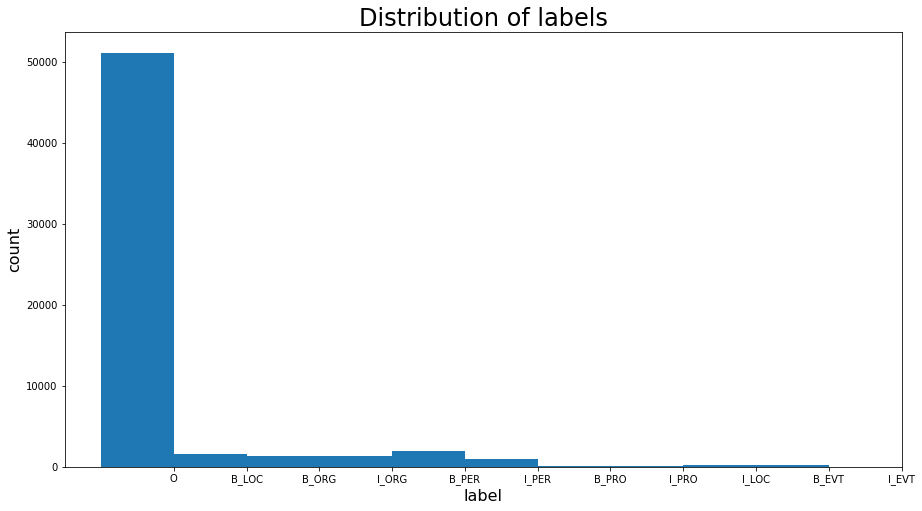

In [9]:
labels_dist = Counter(labels)

plt.figure(figsize=(15, 8))
plt.hist(labels, bins=np.arange(11) - 0.5)
plt.xticks(0.5 + np.arange(len(labels_dist.keys())), labels_dist.keys())
plt.title('Distribution of labels', fontsize=24)
plt.xlabel('label', fontsize=16)
plt.ylabel('count', fontsize=16)
plt.show()

---
Как видим, большая часть лейблов не относится ни к одному из классов.

Посмотрим на распределение лейблов, относящихся к какому-то из классов.

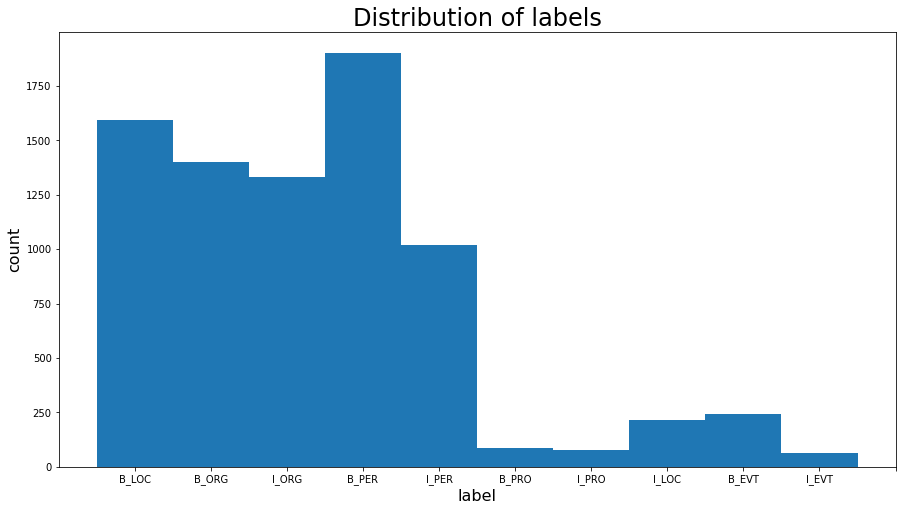

In [10]:
labels_wo_O = list(filter(lambda x: x != 'O', labels))

labels_dist = Counter(labels_wo_O)

plt.figure(figsize=(15, 8))
plt.hist(labels_wo_O, bins=np.arange(11) - 0.5)
plt.xticks(np.arange(len(labels_dist.keys()) + 1), labels_dist.keys())
plt.title('Distribution of labels', fontsize=24)
plt.xlabel('label', fontsize=16)
plt.ylabel('count', fontsize=16)
plt.show()

---
###### 1.2. Remove unexcepted labels from data (if need) and describe how (if need).

В задаче нас просят классифицировать слова на 6 классов, в то время как в датасете встречаются 11 классов.

Можно удалить предложения, в которых встречаются неуместные лейблы (~250 предложений). Это самый простой подход, который уменьшит нам объём данных для обучения. Можно еще заменить все unexpected labels на "O". Опытным путем проверено, что первый вариант лучше.

In [11]:
labels_remain = set(['B_ORG', 'I_PER', 'I_LOC', 'I_ORG', 'B_LOC', 'B_PER', 'O'])
labels = list(train['tags'])

is_remained = [set(l.split(' ')).issubset(labels_remain) for l in labels]

percentage = 100. * (len(train) - sum(is_remained)) / len(train)
train = train[is_remained]

print('deleted sentences are %.2f percents of train set' % percentage)

deleted sentences are 8.41 percents of train set


---
# Part 2 Your own baseline.
###### 2.1 Make your own baseline with this tutorial https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html.

In [12]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [13]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/coder/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [14]:
X_train = []
y_train = []
X_test = []

for i, row in tqdm_notebook(train.iterrows()):
    tokens = row[1].split(' ')
    pos = nltk.pos_tag(tokens)
    X_train.append(sent2features(pos))
    y_train.append(row[2].split(' '))
    
for i, row in tqdm_notebook(test.iterrows()):
    tokens = row[1].split(' ')
    pos = nltk.pos_tag(tokens)
    X_test.append(sent2features(pos))

In [15]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 4.51 s, sys: 6.63 ms, total: 4.52 s
Wall time: 4.52 s


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [16]:
y_pred = crf.predict(X_train)

metrics.flat_f1_score(y_train, y_pred,
                     average='macro', labels=list(crf.classes_))

0.9927993427213615

---
Все обучается, перейдём к кросс-валидации.

---
###### 2.2 Make crossvalidation.

In [17]:
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': sps.expon(scale=0.5),
    'c2': sps.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='macro')

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=5,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)

In [18]:
%%time
rs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.5min finished


CPU times: user 1min, sys: 4.78 s, total: 1min 4s
Wall time: 2min 35s


RandomizedSearchCV(cv=5,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2ea2dc3b50>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2ea2dc3a90>},
                   scoring=make_scorer(flat_f1_score, average=macro),
                   verbose=1)

In [19]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.015537955762374963, 'c2': 0.06987159153555535}
best CV score: 0.7324712869474737
model size: 1.32M


In [20]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=rs.best_params_['c1'],
    c2=rs.best_params_['c2'],
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.015537955762374963,
    c2=0.06987159153555535, keep_tempfiles=None, max_iterations=100)

In [21]:
y_pred = crf.predict(X_test)

In [22]:
lbl_dict = {'B_ORG': 0, 'I_PER': 1, 'I_LOC': 2, 'I_ORG': 3, 'B_LOC': 4, 'B_PER': 5, 'O': 6}

submission_list = []

for row in y_pred:
    for lbl in row:
        submission_list.append(lbl_dict[lbl])

In [23]:
submission = pd.DataFrame({'Id': np.arange(len(submission_list)), 'Predicted': submission_list})

In [24]:
submission.to_csv('submission_baseline.csv', index=False)

---
Данный submission набрал 0.615 f1-score на тестовых данных на kaggle с гиперпараметрами $\text{c1}=0.0036$, $\text{c2}=0.061$.

Использовавшиеся фичи:

1. word.lower() - токен в нижнем регистре
2. word.isupper() - флаг, записан ли токен в верхнем регистре
3. word.istitle() - флаг, начинается ли токен с заглавной буквы
4. postag - тэг токена
5. postag[:2] - первые 2 символа тэга
6. фичи 1-5 для соселних токенов
7. word.isdigit() - флаг, является ли токен числом
8. word[-3:] - суффикс токена длины 3
9. word[-2:] - суффикс токена длины 2
10. BOS - флаг, является ли токен первым в предложении
11. EOS - флаг, является ли токен последним в предложении

Все эти фичи взяты из туториала https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html

---
# Part 3. Your favorite ml algorithm.

---
###### 3.1 Make submission to leaderboard and beat a baseline with your favorite ML algorithm (0.55 macro f1).

подход №1: rusVectores embedding + BiLSTM + CRF

---
разобъем данные на обучение и валидацию

In [15]:
train_data, val_data = train_test_split(train, test_size=0.1, random_state=42)
test_data = test.copy()

labels = []
for i, row in test_data.iterrows():
    labels.append(' '.join(['O'] * len(row[1].split(' '))))

test_data['labels'] = labels

train_data.columns = ['id', 'text', 'labels']
val_data.columns = ['id', 'text', 'labels']
test_data.columns = ['id', 'text', 'labels']

In [16]:
train_data.to_csv('train_data.csv', sep='\t')
val_data.to_csv('val_data.csv', sep='\t')
test_data.to_csv('test_data.csv', sep='\t')

---
загрузим модель эмбеддингов с rusVectores

In [17]:
model = gensim.models.KeyedVectors.load('model.model')

INFO:gensim.utils:loading Word2VecKeyedVectors object from model.model
INFO:gensim.utils:loading vectors from model.model.vectors.npy with mmap=None
INFO:gensim.utils:loading vectors_vocab from model.model.vectors_vocab.npy with mmap=None
INFO:gensim.utils:loading vectors_ngrams from model.model.vectors_ngrams.npy with mmap=None
INFO:gensim.utils:setting ignored attribute vectors_norm to None
INFO:gensim.utils:setting ignored attribute vectors_vocab_norm to None
INFO:gensim.utils:setting ignored attribute vectors_ngrams_norm to None
INFO:gensim.utils:setting ignored attribute buckets_word to None
INFO:gensim.utils:loaded model.model


In [17]:
learn = NerLearner(
    train_df_path="~/study/5course/NLP-mipt/hw2/train_data.csv",
    valid_df_path="~/study/5course/NLP-mipt/hw2/val_data.csv",
    test_df_path="~/study/5course/NLP-mipt/hw2/test_data.csv",
    embedder=model,
    tensorboard_dir="logs",
    hidden_dim=1024,
    lr=0.0004,
    use_embeds=False
)

In [18]:
learn.fit(10)

INFO:root:Start training. Total epochs 10.
INFO:root:                                                                       
epoch 1, average train epoch loss=17.938

  0%|          | 0/195 [00:00<?, ?it/s]        

              precision    recall  f1-score   support

       B_LOC      0.659     0.513     0.577       158
       B_ORG      0.619     0.106     0.181       123
       B_PER      0.555     0.426     0.482       190
       I_LOC      0.000     0.000     0.000        14
       I_ORG      0.667     0.042     0.078        96
       I_PER      0.818     0.094     0.168        96
           O      0.922     0.992     0.956      4841

    accuracy                          0.904      5518
   macro avg      0.606     0.310     0.349      5518
weighted avg      0.886     0.904     0.880      5518



INFO:root:                                                                       
epoch 2, average train epoch loss=4.5087

train loss: 3.6290786266326904:   0%|          | 0/195 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       B_LOC      0.818     0.709     0.759       158
       B_ORG      0.732     0.423     0.536       123
       B_PER      0.789     0.747     0.768       190
       I_LOC      1.000     0.143     0.250        14
       I_ORG      0.535     0.396     0.455        96
       I_PER      0.882     0.698     0.779        96
           O      0.957     0.985     0.971      4841

    accuracy                          0.939      5518
   macro avg      0.816     0.586     0.645      5518
weighted avg      0.934     0.939     0.934      5518



INFO:root:                                                                       
epoch 3, average train epoch loss=3.294

train loss: 3.167675733566284:   1%|          | 2/195 [00:00<00:13, 14.32it/s]

              precision    recall  f1-score   support

       B_LOC      0.870     0.722     0.789       158
       B_ORG      0.680     0.537     0.600       123
       B_PER      0.813     0.779     0.796       190
       I_LOC      1.000     0.143     0.250        14
       I_ORG      0.604     0.635     0.619        96
       I_PER      0.922     0.740     0.821        96
           O      0.965     0.982     0.973      4841

    accuracy                          0.945      5518
   macro avg      0.836     0.648     0.693      5518
weighted avg      0.944     0.945     0.943      5518



INFO:root:                                                                       
epoch 4, average train epoch loss=2.779

train loss: 2.7176783084869385:   1%|          | 2/195 [00:00<00:13, 14.40it/s]

              precision    recall  f1-score   support

       B_LOC      0.867     0.741     0.799       158
       B_ORG      0.650     0.618     0.633       123
       B_PER      0.853     0.795     0.823       190
       I_LOC      0.500     0.143     0.222        14
       I_ORG      0.638     0.625     0.632        96
       I_PER      0.906     0.802     0.851        96
           O      0.969     0.982     0.975      4841

    accuracy                          0.949      5518
   macro avg      0.769     0.672     0.705      5518
weighted avg      0.947     0.949     0.947      5518



INFO:root:                                                                       
epoch 5, average train epoch loss=2.3862

train loss: 2.39485502243042:   1%|          | 2/195 [00:00<00:13, 14.15it/s]

              precision    recall  f1-score   support

       B_LOC      0.873     0.741     0.801       158
       B_ORG      0.644     0.618     0.631       123
       B_PER      0.847     0.789     0.817       190
       I_LOC      0.600     0.214     0.316        14
       I_ORG      0.588     0.625     0.606        96
       I_PER      0.886     0.812     0.848        96
           O      0.971     0.981     0.976      4841

    accuracy                          0.949      5518
   macro avg      0.773     0.683     0.714      5518
weighted avg      0.947     0.949     0.947      5518



INFO:root:                                                                       
epoch 6, average train epoch loss=2.1559

train loss: 2.167495846748352:   1%|          | 2/195 [00:00<00:13, 14.17it/s]

              precision    recall  f1-score   support

       B_LOC      0.873     0.741     0.801       158
       B_ORG      0.646     0.593     0.619       123
       B_PER      0.847     0.789     0.817       190
       I_LOC      0.667     0.286     0.400        14
       I_ORG      0.619     0.625     0.622        96
       I_PER      0.892     0.865     0.878        96
           O      0.970     0.981     0.976      4841

    accuracy                          0.949      5518
   macro avg      0.788     0.697     0.730      5518
weighted avg      0.948     0.949     0.948      5518



INFO:root:                                                                       
epoch 7, average train epoch loss=2.0002

train loss: 2.1292781829833984:   1%|          | 2/195 [00:00<00:14, 13.70it/s]

              precision    recall  f1-score   support

       B_LOC      0.881     0.753     0.812       158
       B_ORG      0.667     0.585     0.623       123
       B_PER      0.859     0.800     0.828       190
       I_LOC      0.667     0.286     0.400        14
       I_ORG      0.630     0.604     0.617        96
       I_PER      0.882     0.854     0.868        96
           O      0.970     0.983     0.976      4841

    accuracy                          0.951      5518
   macro avg      0.794     0.695     0.732      5518
weighted avg      0.948     0.951     0.949      5518



INFO:root:                                                                       
epoch 8, average train epoch loss=1.8894

train loss: 1.9832584857940674:   1%|          | 2/195 [00:00<00:13, 14.27it/s]

              precision    recall  f1-score   support

       B_LOC      0.868     0.747     0.803       158
       B_ORG      0.710     0.577     0.637       123
       B_PER      0.852     0.789     0.820       190
       I_LOC      0.444     0.286     0.348        14
       I_ORG      0.644     0.604     0.624        96
       I_PER      0.901     0.854     0.877        96
           O      0.968     0.983     0.976      4841

    accuracy                          0.950      5518
   macro avg      0.770     0.692     0.726      5518
weighted avg      0.948     0.950     0.949      5518



INFO:root:                                                                       
epoch 9, average train epoch loss=1.8264

train loss: 1.7917031049728394:   1%|          | 2/195 [00:00<00:13, 13.84it/s]

              precision    recall  f1-score   support

       B_LOC      0.874     0.747     0.805       158
       B_ORG      0.689     0.577     0.628       123
       B_PER      0.853     0.795     0.823       190
       I_LOC      0.500     0.286     0.364        14
       I_ORG      0.624     0.604     0.614        96
       I_PER      0.882     0.854     0.868        96
           O      0.969     0.982     0.976      4841

    accuracy                          0.950      5518
   macro avg      0.770     0.692     0.725      5518
weighted avg      0.947     0.950     0.948      5518



INFO:root:                                                                       
epoch 10, average train epoch loss=1.8056



              precision    recall  f1-score   support

       B_LOC      0.874     0.747     0.805       158
       B_ORG      0.689     0.577     0.628       123
       B_PER      0.848     0.795     0.821       190
       I_LOC      0.500     0.286     0.364        14
       I_ORG      0.628     0.615     0.621        96
       I_PER      0.874     0.865     0.869        96
           O      0.969     0.982     0.976      4841

    accuracy                          0.950      5518
   macro avg      0.769     0.695     0.726      5518
weighted avg      0.947     0.950     0.948      5518



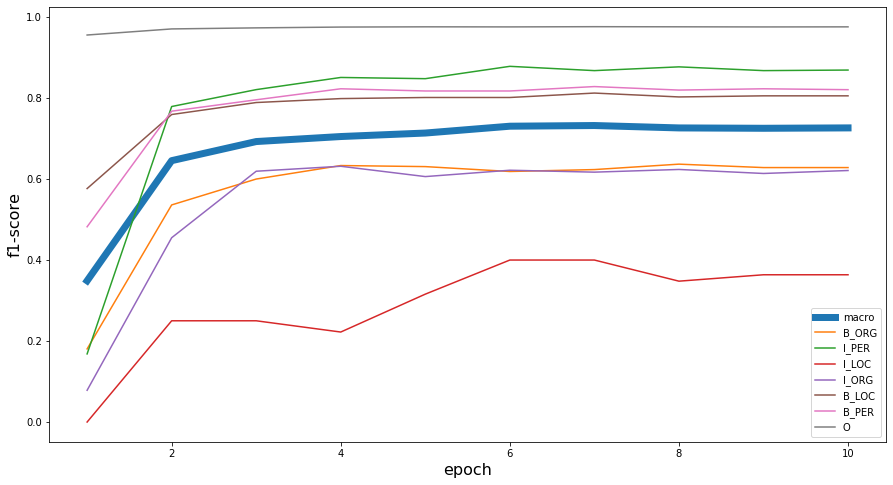

In [19]:
learn.plot_learning_curve()

Сформируем submission

In [ ]:
pred = predict(learn.data.test_dl, learn.model, learn.data.train_ds.idx2label)

In [35]:
lbl_dict = {'B_ORG': 0, 'I_PER': 1, 'I_LOC': 2, 'I_ORG': 3, 'B_LOC': 4, 'B_PER': 5, 'O': 6, '<pad>': 6}

submission_list = []

for row in pred:
    for lbl in row:
        submission_list.append(lbl_dict[lbl])

In [36]:
submission = pd.DataFrame({'Id': np.arange(len(submission_list)), 'Predicted': submission_list})
submission.to_csv('submission_BiLSTM_CRF_10_epochs.csv', index=False)

---
Подход №2: попробуем использовать предобученный BERT в качестве эмбеддера.

Для этого сначала подготовим словарь слов:

In [17]:
words = list(map(str.split, list(train.tokens))) + list(map(str.split, list(test.tokens)))
words = [item for w in words for item in w]
words.append('<pad>')

words = list(set(words))

---
Загрузим модель:

In [18]:
tokenizer = BertTokenizer.from_pretrained('./rubert_cased_L-12_H-768_A-12_pt')
bmodel = BertModel.from_pretrained('./rubert_cased_L-12_H-768_A-12_pt')

---
Запишем все векторные представления слов из словаря в файл:

In [ ]:
with open('bert.wv', 'a') as f:
    for w in tqdm_notebook(words):
        wv = bmodel(**tokenizer(w, return_tensors='pt')).last_hidden_state[:, 0, :].reshape(-1).tolist()
        f.write(w + '\t' + str(wv) + '\n')

In [19]:
bert_wv = {}

with open('bert.wv', 'r') as f:
    for line in tqdm_notebook(f):
        text = line.split('\t')
        word = text[0]
        text = text[1].rstrip()
        bert_wv[word] = np.array(list(map(float, text[1:-1].split(', '))), dtype=np.float32)

In [20]:
class Bert():
    def __init__(self, wv):
        self.wv = wv
        
    def __getitem__(self, text):
        output = [self.wv[word] for word in text]
        return np.stack(output, axis=0)

In [21]:
bert_model = Bert(wv=bert_wv)

In [22]:
learn = NerLearner(
    train_df_path="~/study/5course/NLP-mipt/hw2/train_data.csv",
    valid_df_path="~/study/5course/NLP-mipt/hw2/val_data.csv",
    test_df_path="~/study/5course/NLP-mipt/hw2/test_data.csv",
    embedder=bert_model,
    tensorboard_dir="logs",
    embedding_size=768,
    hidden_dim=1024,
    lr=0.0004,
    use_embeds=False
)

In [ ]:
learn.fit(10)

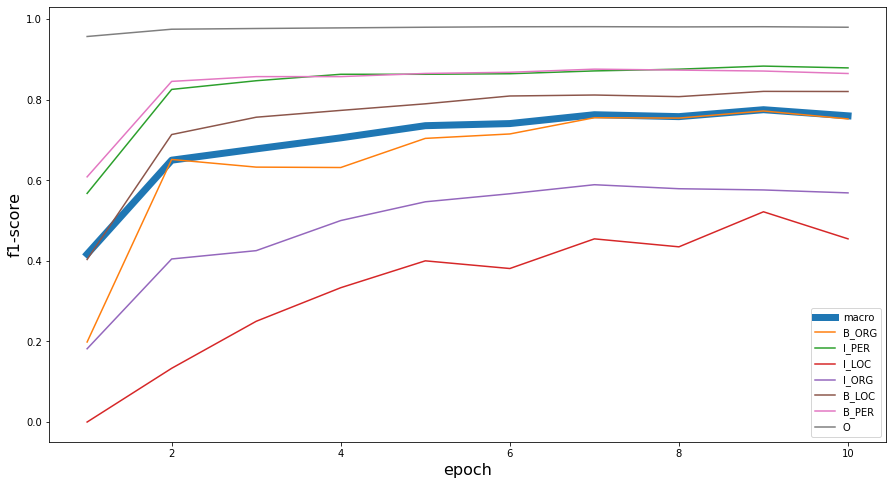

In [24]:
learn.plot_learning_curve()

Сформируем submission:

In [37]:
pred = predict(learn.data.test_dl, learn.model, learn.data.train_ds.idx2label)

In [38]:
lbl_dict = {'B_ORG': 0, 'I_PER': 1, 'I_LOC': 2, 'I_ORG': 3, 'B_LOC': 4, 'B_PER': 5, 'O': 6, '<pad>': 6}

submission_list = []

for row in pred:
    for lbl in row:
        submission_list.append(lbl_dict[lbl])

In [40]:
submission = pd.DataFrame({'Id': np.arange(len(submission_list)), 'Predicted': submission_list})
submission.to_csv('submission_BERT_BiLSTM_CRF_10_epochs.csv', index=False)

---
Подход №3: DeepPavlov NER model

In [20]:
from deeppavlov import configs, build_model

In [22]:
ner_model = build_model(configs.ner.ner_rus_bert, download=True)

2021-03-17 13:17:54.859 INFO in 'deeppavlov.download'['download'] at line 138: Skipped http://files.deeppavlov.ai/deeppavlov_data/bert/rubert_cased_L-12_H-768_A-12_v1.tar.gz download because of matching hashes
INFO:deeppavlov.download:Skipped http://files.deeppavlov.ai/deeppavlov_data/bert/rubert_cased_L-12_H-768_A-12_v1.tar.gz download because of matching hashes
2021-03-17 13:17:57.371 INFO in 'deeppavlov.download'['download'] at line 138: Skipped http://files.deeppavlov.ai/deeppavlov_data/ner_rus_bert_v1.tar.gz download because of matching hashes
INFO:deeppavlov.download:Skipped http://files.deeppavlov.ai/deeppavlov_data/ner_rus_bert_v1.tar.gz download because of matching hashes

2021-03-17 13:17:58.850 INFO in 'deeppavlov.core.data.simple_vocab'['simple_vocab'] at line 115: [loading vocabulary from /home/coder/.deeppavlov/models/ner_rus_bert/tag.dict]
INFO:deeppavlov.core.data.simple_vocab:[loading vocabulary from /home/coder/.deeppavlov/models/ner_rus_bert/tag.dict]









The Te

In [25]:
lbl_dict = {'B_ORG': 0, 'I_PER': 1, 'I_LOC': 2, 'I_ORG': 3, 'B_LOC': 4, 'B_PER': 5, 'O': 6, '<pad>': 6}
deeppavlov_lbl_dict = {'B-ORG': 0, 'I-PER': 1, 'I-LOC': 2, 'I-ORG': 3, 'B-LOC': 4, 'B-PER': 5, 'O': 6, '<pad>': 6}

In [26]:
def accuracy_evaluate(data):
    accuracy_array = []
    for i in tqdm(range(len(data['text']))):
        predict = ner_model([data['text'].iloc[i]])[1][0]
        true_label = data['labels'].iloc[i].split()
        number_predict = labels_to_numbers(predict, deeppavlov_lbl_dict)
        number_true_label = labels_to_numbers(true_label, lbl_dict)
        while len(number_predict) > len(number_true_label):
            number_true_label.append(6)
        while len(number_predict) < len(number_true_label):
            number_predict.append(6)

        number_predict = np.array(number_predict)
        number_true_label = np.array(number_true_label)
        accuracy = (number_predict == number_true_label).mean()
        accuracy_array.append(accuracy)
    return accuracy_array

In [27]:
def make_submission_list(data):
    submission_list = []
    for i in tqdm(range(len(data['text']))):
        predict = ner_model([data['text'].iloc[i]])[1][0]
        number_predict = labels_to_numbers(predict, deeppavlov_lbl_dict)
        if len(number_predict) > len(data['text'].iloc[i].split()):
            number_predict = number_predict[:len(data['text'].iloc[i].split())]
        for item in number_predict:
            submission_list.append(item)
    return submission_list

In [28]:
def labels_to_numbers(labels, lbl_dict):
    out_array = []
    for item in labels:
        out_array.append(lbl_dict[item])
    return out_array

In [29]:
deeppavlov_submission = make_submission_list(test_data)

100%|██████████| 2714/2714 [03:49<00:00, 11.83it/s]


In [30]:
deep_submission = pd.DataFrame({'Id': np.arange(len(deeppavlov_submission)), 'Predicted': deeppavlov_submission})

In [31]:
np.unique(deep_submission['Predicted'])

array([0, 1, 2, 3, 4, 5, 6])

In [32]:
deep_submission.to_csv('submission_DeepPavlov.csv', index=False)

In [33]:
val_data.head()

,id,text,labels
3387,3387,"Однако никто не может объяснить , почему это п...",O O O O O O O O O O O O O O O O O O O O O O O O O
418,418,"На фоне волны недовольства , которую вызвал оп...",O O O O O O O O O O O O O O B_PER I_PER
3505,3505,"В пятницу , 21 января , на досудебных слушания...",O O O O O O O O O O O O O O O O O O O O B_PER ...
1770,1770,"Политики приходят и уходят , но проблемы , кот...",O O O O O O O O O O O O O O O O
1385,1385,В течение этого времени британская сторона не ...,O O O O O O O O O O O O O O O O O B_ORG


---
Попытка №5: NERDA

https://towardsdatascience.com/easy-fine-tuning-of-transformers-for-named-entity-recognition-d72f2b5340e3

In [17]:
training = {}
training["sentences"] = [s.split() for s in train_data['text']]
training["tags"] = [s.split() for s in train_data['labels']]

validation = {}
validation["sentences"] = [s.split() for s in val_data['text']]
validation["tags"] = [s.split() for s in val_data['labels']]

tag_scheme = [
'B_PER',
'I_PER',
'B_ORG',
'I_ORG',
'B_LOC',
'I_LOC',
]

transformer = 'DeepPavlov/rubert-base-cased'
# transformer = 'bert-base-multilingual-uncased'
# transformer = 'bert-base-NER'

# hyperparameters for network
dropout = 0.1
# hyperparameters for training
training_hyperparameters = { 
    'epochs' : 4, 
    'warmup_steps' : 500, 
    'train_batch_size': 6, 
    'learning_rate': 0.0001,
}

In [18]:
model = NERDA( 
    dataset_training = training, 
    dataset_validation = validation, 
    tag_scheme = tag_scheme,  
    tag_outside = 'O', 
    transformer = transformer, 
    dropout = dropout, 
    hyperparameters = training_hyperparameters,
    max_len = 256
)

Device automatically set to: cuda


In [19]:
model.train()

  0%|          | 0/520 [00:00<?, ?it/s]


 Epoch 1 / 4


  0%|          | 0/520 [00:00<?, ?it/s]

Train Loss = 0.35550038295690545 Valid Loss = 0.13531793467700481

 Epoch 2 / 4


  0%|          | 0/520 [00:00<?, ?it/s]

Train Loss = 0.1141438651341909 Valid Loss = 0.07160026450450956

 Epoch 3 / 4


  0%|          | 0/520 [00:00<?, ?it/s]

Train Loss = 0.04599428994607968 Valid Loss = 0.0760069443706677

 Epoch 4 / 4


100%|██████████| 44/44 [00:04<00:00,  8.85it/s]


Train Loss = 0.018684987347492448 Valid Loss = 0.07789866593719291


'Model trained successfully'

In [20]:
model.evaluate_performance(training)

,Level,F1-Score
0,B_PER,0.999063
1,I_PER,0.999432
2,B_ORG,0.998347
3,I_ORG,0.998743
4,B_LOC,0.998188
5,I_LOC,0.997455
0,AVG_MICRO,0.998684
0,AVG_MACRO,0.998538


In [20]:
model.evaluate_performance(validation)

,Level,F1-Score
0,B_PER,0.965879
1,I_PER,0.979381
2,B_ORG,0.872587
3,I_ORG,0.860215
4,B_LOC,0.942308
5,I_LOC,0.689655
0,AVG_MICRO,0.924320
0,AVG_MACRO,0.885004


---
В процессе тестирования столкнулись с проблемой: модель выдает в качестве предсказания больше тэгов, чем требуется из-за внутреннего разбиения на токены внутри токенизатора.

Решение: для таких токенов брать предсказание из модели BiLSTM + CRF.

In [20]:
def labels_to_numbers(labels, lbl_dict):
    if len(labels[1]) == 1:
        out_array = [lbl_dict[item] for item in labels[1][0]]
    else:
        out_array = []
        for array_ in labels[1]:
            current_array = [lbl_dict[item] for item in array_]
            out_array.extend(current_array)
    return out_array

lbl_dict = {'B_ORG': 0, 'I_PER': 1, 'I_LOC': 2, 'I_ORG': 3, 'B_LOC': 4, 'B_PER': 5, 'O': 6, '<pad>': 6}

In [23]:
def make_submission_list(ner_model, data):
    submission_list = []
    count_bigger = []
    count_smaller = []
    for i in tqdm(range(len(data['text']))):
        predict = ner_model.predict_text(data['text'].iloc[i])
        number_predict = labels_to_numbers(predict, lbl_dict)
        assert len(number_predict) == len(data['text'].iloc[i].split())
        for item in number_predict:
            submission_list.append(item)
    return submission_list, count_bigger, count_smaller

In [22]:
counter = 0
for item in test_data['text']:
    counter += len(item.split())
    
print(counter)

56409


In [24]:
NERDA_submission_list, bigger, smaller = make_submission_list(model, test_data)

100%|██████████| 2714/2714 [03:40<00:00, 12.29it/s]


In [25]:
len(NERDA_submission_list)

56409

In [97]:
nerda_submission = pd.DataFrame({'Id': np.arange(len(NERDA_submission_list)), 'Predicted': NERDA_submission_list})

In [98]:
nerda_submission.to_csv('submission_nerda_dp_bs6_epochs4.csv', index=False)

---
# Part 4. Results.

Получившиеся результаты:

|№| метод         | f1-score      |
|----------| ------------- |:-------------:|
|1| sclearn-CRF | 0.61 |
|2| Rusvectores embedder BiLSTM + CRF | 0.55 |
|3| trainable Embedder + BiLSTM + CRF      | 0.36      |
|4| BERT embedder + BiLSTM + CRF | **0.65**      |
|5| pretrained ner_rus_bert from DeepPavlov | **0.68**      |
|6| NERDA epochs=4 bs=6 | **0.79**      |
|7| NERDA DeepPavlov transformer epochs=4 bs=6 | **0.82**      |

Модели №2-4 построены на основе кода с семинара и отличаются только эмбеддером.

Далее мы решили взять предобученный БЕРТ и накрутить сверху линейный классификатор. В качестве берта взяли мультязычный bert base, и начали это все дело файнтюнить на нашем датасете. Для этого использовали фреймворк NERDA, в котором это все уже было реализовано (единственное нам пришлось немножко покопаться в кишках т.к. токены бились не так как надо и их было больше чем надо) это решение набрало 0.79.

Далее мы решили взять вместо этого трансформера DeepPavlov/rubert по сути это тот же мультиязычный bert base дообученный на русской википедии. Это позволило сходу улучшить наш скор до 0.823.

Хотели еще поприменять поиск гиперпараметров, более сложный классификатор на фичах, которые выдает трансформер, фейк Квантование линейного слоя (зачастую фейк квантование в 8 бит работает как некая регуляризация и может улучшить результат).
Но у нас у всех работа и другие курсы и мы не успели)

Наихудшее качество получается для лейблов I_LOC, I_ORG -- лейблов, указывающих на продолжение сущностей организации и локации.